In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import glob
import os

import dask

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.50

## Dask cluster

In [2]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    account="pches",
    # account="open",
    cores=1,
    memory="4GB",
    walltime="00:20:00",
)

cluster.scale(jobs=20)

In [3]:
# print(cluster.job_script())

In [4]:
from dask.distributed import Client

client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.0.174:37395,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Preliminaries

In [10]:
# Directories
nldas_path = "/storage/group/pches/default/public/NLDAS"
smap_path = "/storage/group/pches/default/public/SMAP"
log_path = "/storage/home/dcl5300/work/current_projects/wbm_soilM_crop_uc_lafferty-etal-2024-tbd/code/logs"
project_data_path = '/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA'

## Soil moisture 'obs' plots

In [16]:
# Error calculation function
def calculate_error_metrics(ds1, ds2, weekly_anom):
    # Weekly anomalies if needed
    def get_weekly_anomaly(ds):
        ds_tmp = ds.copy()
        ds_tmp = ds_tmp.assign_coords(week=ds_tmp.time.dt.strftime("%W"))
        return (ds_tmp.groupby('week') - ds_tmp.groupby("week").mean("time"))
    
    # Calculate weekly anom if desired
    if weekly_anom:
        ds1_tmp = get_weekly_anomaly(ds1)
        ds2_tmp = get_weekly_anomaly(ds2)
    else:
        ds1_tmp = ds1.copy()
        ds2_tmp = ds2.copy()
    
    # Linear correlation
    out_corr = xr.corr(ds1_tmp, ds2_tmp, dim='time')
    
    # MSE
    out_mse = np.sqrt(((ds1_tmp - ds2_tmp)**2)).mean(dim='time')

    # Merge and return
    out = xr.merge([xr.Dataset({'perason_r':out_corr}),
                    xr.Dataset({'rmse':out_mse})])

    return out

In [7]:
# Read all
ds_vic = xr.open_mfdataset(f'{nldas_path}/VIC/daily/*A20*.nc')['SOILM0_100cm'].isel(depth=0)
ds_noah = xr.open_mfdataset(f'{nldas_path}/NOAH/daily/*A20*.nc')['SOILM'].isel(depth=1)
ds_mosaic = xr.open_mfdataset(f'{nldas_path}/MOSAIC/daily/*A20*.nc')['SOILM'].isel(depth=1)

ds_smap = xr.open_mfdataset(f'{smap_path}/processed_nldas_grid/SMAP_L4_SM_gph_all_nldas_*.nc')['sm_rootzone']

In [8]:
%%time 

# Calculate all error metrics
weekly_anom = True

vic_noah_error = calculate_error_metrics(ds_vic, ds_noah, weekly_anom).compute()
vic_mosaic_error = calculate_error_metrics(ds_vic, ds_mosaic, weekly_anom).compute()
vic_smap_error = calculate_error_metrics(ds_vic, ds_smap, weekly_anom).compute()

noah_mosaic_error = calculate_error_metrics(ds_noah, ds_mosaic, weekly_anom).compute()
noah_smap_error = calculate_error_metrics(ds_noah, ds_smap, weekly_anom).compute()

mosaic_smap_error = calculate_error_metrics(ds_mosaic, ds_smap, weekly_anom).compute()

CPU times: user 6min, sys: 8.16 s, total: 6min 8s
Wall time: 6min 19s


In [ ]:
# Store all
vic_noah_error.to_netcdf(f'{project_data_path}/WBM/soil_obs_errors/vic_noah_errors.nc')
vic_mosaic_error.to_netcdf(f'{project_data_path}/WBM/soil_obs_errors/vic_mosaic_errors.nc')
vic_smap_error.to_netcdf(f'{project_data_path}/WBM/soil_obs_errors/vic_smap_errors.nc')

noah_mosaic_error.to_netcdf(f'{project_data_path}/WBM/soil_obs_errors/noah_mosaic_errors.nc')
noah_smap_error.to_netcdf(f'{project_data_path}/WBM/soil_obs_errors/noah_smap_errors.nc')

mosaic_smap_error.to_netcdf(f'{project_data_path}/WBM/soil_obs_errors/mosaic_smap_errors.nc')

In [ ]:
# fig, axs = plt.subplots(1,2, figsize=(12,8),
#                         subplot_kw={'projection':ccrs.LambertConformal()},
#                        gridspec_kw={'wspace':0.05})

# p_corr = vic_noah_error.corr.plot(ax=axs[0], transform=ccrs.PlateCarree(),
#                                   add_colorbar=False,
#                                   levels=11
#                                  )
# p_mse = vic_noah_error.mse.plot(ax=axs[1], transform=ccrs.PlateCarree(),
#                                 add_colorbar=False,
#                                 levels=11
#                                )

# axs[0].add_feature(cfeature.STATES, edgecolor='white', linewidth=1)
# axs[1].add_feature(cfeature.STATES, edgecolor='white', linewidth=1)

# fig.colorbar(p_corr, ax = axs[0],
#              orientation="horizontal",
#              label="Linear correlation",
#              pad=0.04)

# fig.colorbar(p_mse, ax = axs[1],
#              orientation="horizontal",
#              label="Mean Square Error",
#              pad=0.04)

# fig.suptitle("Noah VIC soil moisture anomaly comparison (2016-2022)", y=0.63)

# plt.show()

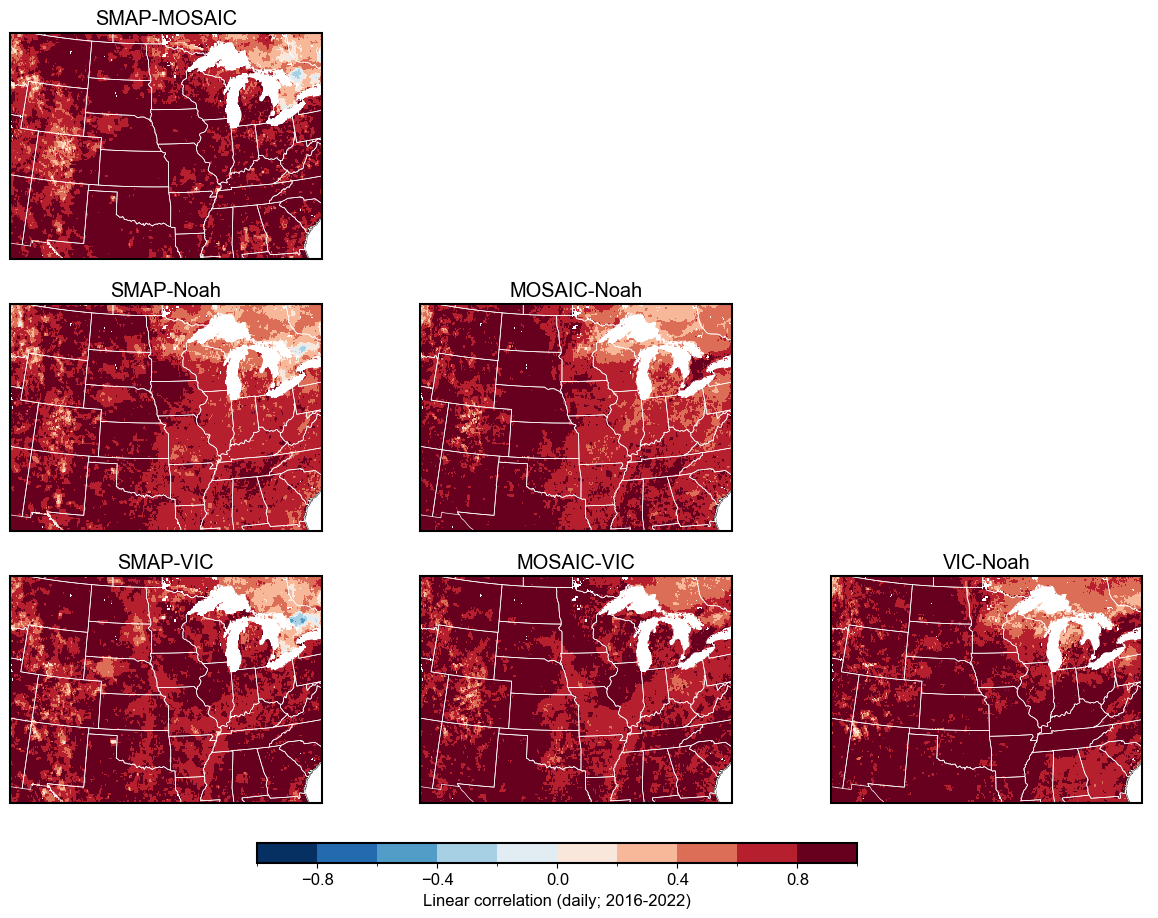

In [12]:
# Correlation plot
fig, axs = plt.subplots(3,3, figsize=(15,10), subplot_kw=dict(projection=ccrs.LambertConformal()))

xlims = [-110, -80] # central US
ylims = [30,49] # central US

mosaic_smap_error.corr.plot(ax=axs[0,0], vmin=-1, vmax=1, cmap="RdBu_r", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[0,0].set_title("SMAP-MOSAIC")

noah_smap_error.corr.plot(ax=axs[1,0], vmin=-1, vmax=1, cmap="RdBu_r", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[1,0].set_title("SMAP-Noah")

vic_smap_error.corr.plot(ax=axs[2,0], vmin=-1, vmax=1, cmap="RdBu_r", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[2,0].set_title("SMAP-VIC")

noah_mosaic_error.corr.plot(ax=axs[1,1], vmin=-1, vmax=1, cmap="RdBu_r", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[1,1].set_title("MOSAIC-Noah")

vic_mosaic_error.corr.plot(ax=axs[2,1], vmin=-1, vmax=1, cmap="RdBu_r", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[2,1].set_title("MOSAIC-VIC")

p=vic_noah_error.corr.plot(ax=axs[2,2], vmin=-1, vmax=1, cmap="RdBu_r", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[2,2].set_title("VIC-Noah")

for ax in [axs[0,0],axs[1,0],axs[2,0],axs[1,1],axs[2,1],axs[2,2]]:
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='white', linewidth=0.5)
    ax.set_extent([xlims[0], xlims[1], ylims[0], ylims[1]], ccrs.Geodetic())
    
axs[0,1].axis('off')
axs[0,2].axis('off')
axs[1,2].axis('off')

cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02])
cbar = fig.colorbar(p,
                    cax=cbar_ax,
                    orientation="horizontal",
                    label="Linear correlation (daily; 2016-2022)")

# plt.savefig('./figs/pearson_GMFD-PRISM-gridMET_1981-2014_Hamon_midwest.png', dpi=600)
plt.show()

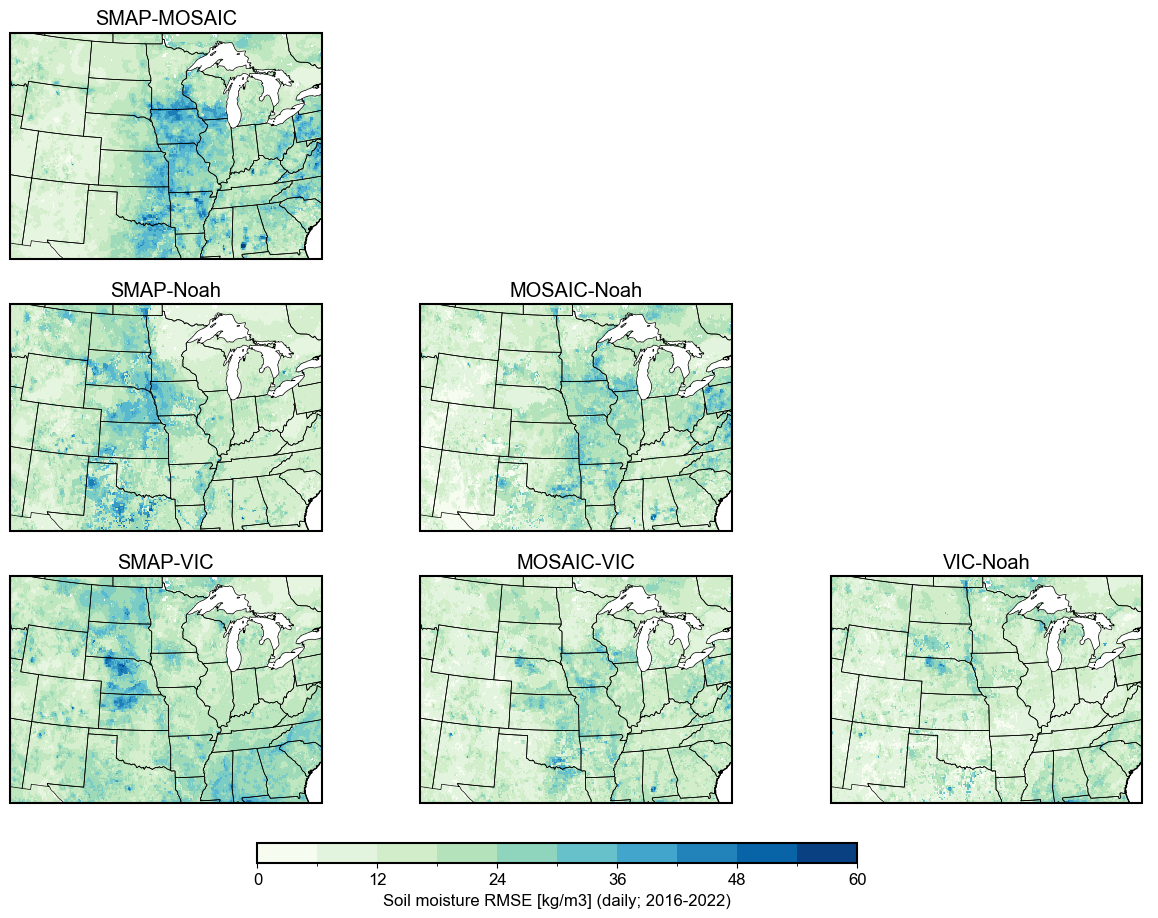

In [15]:
# RMSE plot
fig, axs = plt.subplots(3,3, figsize=(15,10), subplot_kw=dict(projection=ccrs.LambertConformal()))

xlims = [-110, -80] # central US
ylims = [30,49] # central US

mosaic_smap_error.mse.plot(ax=axs[0,0], vmin=0, vmax=60, cmap="GnBu", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[0,0].set_title("SMAP-MOSAIC")

noah_smap_error.mse.plot(ax=axs[1,0], vmin=0, vmax=60, cmap="GnBu", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[1,0].set_title("SMAP-Noah")

vic_smap_error.mse.plot(ax=axs[2,0], vmin=0, vmax=60, cmap="GnBu", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[2,0].set_title("SMAP-VIC")

noah_mosaic_error.mse.plot(ax=axs[1,1], vmin=0, vmax=60, cmap="GnBu", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[1,1].set_title("MOSAIC-Noah")

vic_mosaic_error.mse.plot(ax=axs[2,1], vmin=0, vmax=60, cmap="GnBu", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[2,1].set_title("MOSAIC-VIC")

p=vic_noah_error.mse.plot(ax=axs[2,2], vmin=0, vmax=60, cmap="GnBu", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[2,2].set_title("VIC-Noah")

for ax in [axs[0,0],axs[1,0],axs[2,0],axs[1,1],axs[2,1],axs[2,2]]:
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
    ax.set_extent([xlims[0], xlims[1], ylims[0], ylims[1]], ccrs.Geodetic())
    
axs[0,1].axis('off')
axs[0,2].axis('off')
axs[1,2].axis('off')

cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02])
cbar = fig.colorbar(p,
                    cax=cbar_ax,
                    orientation="horizontal",
                    label="Soil moisture RMSE [kg/m3] (daily; 2016-2022)")

# plt.savefig('./figs/pearson_GMFD-PRISM-gridMET_1981-2014_Hamon_midwest.png', dpi=600)
plt.show()